In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import svgutils.transform as sg
import sys 
import os
import math as m
#import win32com.client as win32
from scipy import integrate
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from pathlib import Path
from decimal import Decimal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xlrd

In [2]:
#PARAMETERS THAT NEED TO BE MANUALLY SET
Material='TiN'
Motif= ''
sample= "Q294E"
FTJ = "br32"
Cycle_shape='Squared'
Waiting = True                     #define if there's a pause included in the file before the PUND signal
pund_1_detailed = False            #tells if there's dats for the pund 2 to 9

if Motif=='':
    data_folder = Path("/home/ngariepy/Documents/UdeS/T4/Keithley/" +str(Material)+'/'+str(sample)+'/'+str(FTJ))
else:
    data_folder = Path("/home/ngariepy/Documents/Udes/T4/Keithley/"+str(Material)+'/'+str(Motif)+'/'+str(sample)+'/'+str(FTJ))                                      
#d=50 #diameter in um
#S=m.pi/4*(d*1e-4)**2 #surface en cm²
t_ox= 9.4e-7 #épaisseur de HZO en cm

S = 1936e-8 #surface en cm²

#TO CALCULATE ALL THE TIMINGS WHEN CURRENT VALUES ARE USEFULL
pentep = 50e-6 #rising time of the pulse in s
palierp = 0 #width of the pund pulse in s
inter = 10e-6 #time between pulses
tpulse = 2*pentep + palierp + inter

#If pulse shape is squared
rise = 500e-9 #rise time in s
width = 50e-6 #pulse width in s
space = 10e-6 #time between 2 pulses in s

#Choose the cycle you want to plant by defining the Cycle_to_plot variable (also used to extract certain parameters)
Cycle_to_plot = 1e4
f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)
timescale = 1e6                        #define the timescale to plot (default in µs)
units = 1e6                            #define the units (default is µA)

In [3]:
#HERE ARE DEFINED ALL THE FUNCTIONS USED IN THIS CODE
def TimeFilter (ti, tf, signal):                            #take the signal values taken between Ti and Tf
    cycle = (signal.TimeOutput >= (ti + signal.TimeOutput[0])) & (signal.TimeOutput < (tf + signal.TimeOutput[0]))
    pulse = signal[cycle]
    return pulse

def AddCycleID (CyclesList, order, nb):           #Create a list corresponding to the number of cycles done
    if order==0 :
        CyclesList.append(float(nb-1))
    else :                  
        CyclesList.append(float(nb)*10**(order-1))
    return CyclesList

def isworking (test, values):
    Settings = test.sheet_by_name('Settings')
    Compliance = float(Settings.cell_value(16,3))
    Tolerance = 1.12                                        #tolerance if there's an unexpected peak of current 
    check = False
    if values.VMeasCh1.empty == False:
        ToBeChecked = TimeFilter(inter, 2*pentep, values)   #remove the discharge current that can induce false wrongs
        if ToBeChecked.VMeasCh1.empty == False:                     #check if the sequence wasn't stopped manually
            if (max(abs(ToBeChecked.IMeasCh2))) < (Compliance * Tolerance) :        #check if there's no electrical breakdown
                check = True
    return check

def SplitCurrent (values, P, U, N, D, PN, UD):
    a=['']
    b=['']
    P.append(TimeFilter(0, tpulse, values))
    U.append(TimeFilter(tpulse, 2*tpulse, values))
    N.append(TimeFilter(2*tpulse, 3*tpulse, values))
    D.append(TimeFilter(3*tpulse, 4*tpulse, values))
    a[0]=pd.concat([P[-1],N[-1]],axis=0)
    b[0]=pd.concat([U[-1],D[-1]],axis=0)
    PN.append(a[0])
    UD.append(b[0])
    PN[-1] = PN[-1].reset_index()
    UD[-1] = UD[-1].reset_index()
    P[-1] = P[-1].reset_index()
    U[-1] = U[-1].reset_index()
    N[-1] = N[-1].reset_index()
    D[-1] = D[-1].reset_index()
    return P, U, N, D, PN, UD
    
def getTime (index, Ferro, nonFerro, nb):
    t = []
    instant = 0
    last = Ferro.TimeOutput[0]
    for i in [Ferro, nonFerro]:
        if i is Ferro:
            instant += i.TimeOutput[0]-last
        else:
            instant += i.TimeOutput[0]- tpulse -last
        t.append(instant*nb)
        for j in range(1, len(i)):
            instant += i.TimeOutput[j]-i.TimeOutput[j-1]
            t.append(instant*nb)
        last = i['TimeOutput'].iloc[-1]
    return t

def getPUND (pos, neg, nb, status):
    if status == False : 
        pause = 0      
    else:
        pause = inter
        
    Ipos1 = TimeFilter(pause, pentep+pause, pos).IMeasCh2.values
    Ipos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).IMeasCh2.values
    Ipos = np.append(Ipos1,Ipos2)
    Vpos1 = TimeFilter(pause, pause+pentep, pos).VMeasCh1.values
    Vpos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).VMeasCh1.values
    Vpos = np.append(Vpos1,Vpos2)
    #Vpos = np.delete(Vpos, 0)
    tpos1 = TimeFilter(pause, pentep+pause, pos).TimeOutput.values
    tpos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).TimeOutput.values-palierp
    tpos = np.append(tpos1, tpos2)
    
    Ineg1 = TimeFilter(pause, pentep+pause, neg).IMeasCh2.values
    Ineg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).IMeasCh2.values
    Ineg = np.append(Ineg1,Ineg2)
    Vneg1 = TimeFilter(pause, pentep+pause, neg).VMeasCh1.values
    Vneg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).VMeasCh1.values
    Vneg = np.append(Vneg1,Vneg2)
    #Vneg = np.delete(Vneg, 0)
    tneg1 = TimeFilter(pause, pentep+pause, neg).TimeOutput.values
    tneg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).TimeOutput.values-palierp
    tneg = np.append(tneg1, tneg2)
    
    #Ppos = integrate.cumulative_trapezoid(Ipos, tpos) * nb * 1e6/S
    #Pneg = integrate.cumulative_trapezoid(Ineg, tneg) * nb * 1e6/S
    Ppos = integrate.cumulative_trapezoid(nb * Ipos, tpos, initial=0) * 1e6/S
    Pneg = integrate.cumulative_trapezoid(nb * Ineg, tneg, initial=0) * 1e6/S
    Prpos = Ppos[-1]                                                              
    Prneg = Pneg[-1]
    c1 = Ppos[-1]/2
    c2 = Pneg[-1]/2
    return Ppos-c1, Pneg-c2, Prpos-c1, Prneg-c2, Vpos, Vneg

def the_equalizer (arrays):
    lengths = list()
    for x in range (len(arrays)) :
        lengths.append(len(arrays[x]))
    for x in range (len(arrays)) :
        arrays[x] = arrays[x][:min(lengths)]
    return arrays

def rescale (pos, neg, pr):
    if pos[-1] >= neg[0]:
        t = pos[-1] - neg[0] - abs(pos[-2] - pos[-1])  #pour enlever l'espece de palier
        neg = neg + t
        pr = pr + t
    else:
        t = neg[0] - pos[-1] + abs(pos[-2] - pos[-1])  #pour enlever l'espece de palier
        neg = neg - t
        pr = pr-t
    return neg, pr

def get_Ec (polar, tension):
    X=[]
    Y=[]
    i=1
    X.append(tension[0])
    if polar[0]>0:
        Y.append(-polar[0])
    else:
        Y.append(polar[0])
    while abs(tension[i])>=abs(tension[i-1]):
        X.append(tension[i])
        if polar[0]>0:
            Y.append(-polar[i])
        else:
            Y.append(polar[i])
        i+=1
    Ec = np.interp(0, Y, X)
    return Ec

def get_leakage (current_pos, current_neg, nb, status):
    leak_pos_signal = [] 
    leak_neg_signal = [] 
    
    if status == False : 
        pause = 0
    else:
        pause = inter
    if palierp!=0:
        leak_pos_signal = TimeFilter(pause+pentep+palierp/2, pause+pentep+palierp, current_pos).IMeasCh2.values
        leak_neg_signal = TimeFilter(pause+pentep+palierp/2, pause+pentep+palierp, current_neg).IMeasCh2.values
        leakage_pos = sum(leak_pos_signal) / len(leak_pos_signal)
        leakage_neg = sum(leak_neg_signal) / len(leak_neg_signal)
        density_pos = leakage_pos * nb / S 
        density_neg = leakage_neg * nb / S
    else:
        leak_pos_signal = TimeFilter(pause, pause+pentep, current_pos).IMeasCh2.values
        leak_neg_signal = TimeFilter(pause, pause+pentep, current_neg).IMeasCh2.values
        leakage_pos = leak_pos_signal[-1]
        leakage_neg = leak_neg_signal[-1]
        density_pos = leakage_pos * nb / S 
        density_neg = leakage_neg * nb / S
    return leakage_pos*nb, leakage_neg*nb, density_pos, density_neg

def create_cycle (MaxV, MinV):
    if Cycle_shape == 'Squared':
        stepsT = [0, rise, width, rise, space, rise, width, rise, space]
        tension = [0, MaxV, MaxV, 0, 0, MinV, MinV, 0, 0]
    elif Cycle_shape == 'Triangle':
        stepsT = [0, pentep, pentep, inter, pentep, pentep, inter]
        tension = [0, MaxV, 0, 0, MinV, 0, 0]
    else:
        stepsT = [0, pentep, palierp, pentep, inter, pentep, palierp, pentep, inter]
        tension = [0, MaxV, MaxV, 0, 0, MinV, MinV, 0, 0]
    j=0
    time=[]
    for  i in stepsT:
        j+=i*timescale
        time.append(j)
        
    for x in time:
        x *= timescale 
        
    return time, tension 

def round_x (n, x):
    if n<0:
        return m.floor(n / float(x)) * x
    else:
        return m.ceil(n / float(x)) * x

In [7]:
#OPEN ALL THE VALID FILES AND CREATE LISTS CONTAINING ALL THE CURRENTS MEASURED DURING THE PUND
x = 0                   
j = 0
CyclesID = []
P_current = []
U_current = []
N_current = []
D_current = []
PN_current = []
UD_current = []
while os.path.isfile(data_folder / ('pund_'+ str(x) + '.xls')) == True :
    file = 'pund_'+ str(x) + '.xls'
    wb = xlrd.open_workbook(data_folder / file, logfile = open(os.devnull, 'w'))
    nbdatas = len(wb.sheets()) - 2                  #Calculate the number of sheets in the file
    Current = ['']*nbdatas                      #Create an array corresponding to the number of runs
    print('*' + file + " opened")
    
    Current[0] = pd.read_excel(wb, 'Data')
    SplitCurrent(Current[0], P_current, U_current, N_current, D_current, PN_current, UD_current)        #Add the corresponding lines to both ON and OFF list of currents
    AddCycleID(CyclesID, x, 2)
    
    if isworking(wb, P_current[j]) & isworking(wb, U_current[j]) & isworking(wb, N_current[j]) & isworking(wb, D_current[j]):
        #print ("#" + str(j) + " Cycle " + str(CyclesID[j]) + " valid")
        j += 1
        if x==1 and pund_1_detailed==False:
            CyclesID = CyclesID[:-1]
            CyclesID.append(float(10))
        for y in range(2, nbdatas+1):
            Current[y-1] = pd.read_excel(wb, 'Cycle'+str(y))
            SplitCurrent(Current[y-1], P_current, U_current, N_current, D_current, PN_current, UD_current)
            AddCycleID(CyclesID, x, y+1)
            if isworking(wb, P_current[j]) & isworking(wb, U_current[j]) & isworking(wb, N_current[j]) & isworking(wb, D_current[j]):
                #print("#" + str(j) + " Cycle "+ str(CyclesID[j])+ " valid")
                j += 1
            else:
                print("#" + str(j) + " Cycle " + str(CyclesID[j]) + " not valid")
                CyclesID = CyclesID[:-1]
                P_current = P_current[:-1]
                U_current = U_current[:-1]
                N_current = N_current[:-1]
                D_current = D_current[:-1]
                PN_current = PN_current[:-1]
                UD_current = UD_current[:-1]
    else:
        print("#" + str(j) + " Cycle " + str(CyclesID[j]) + " not valid")
        CyclesID = CyclesID[:-1]
        P_current = P_current[:-1]
        U_current = U_current[:-1]
        N_current = N_current[:-1]
        D_current = D_current[:-1]
        PN_current = PN_current[:-1]
        UD_current = UD_current[:-1]
    x += 1

Index = CyclesID.index(Cycle_to_plot)
Vmax = float("{:.1f}".format(float(max(PN_current[Index].VMeasCh1))))
Vmin = float("{:.1f}".format(float(min(PN_current[Index].VMeasCh1))))

*pund_0.xls opened
*pund_1.xls opened
*pund_2.xls opened


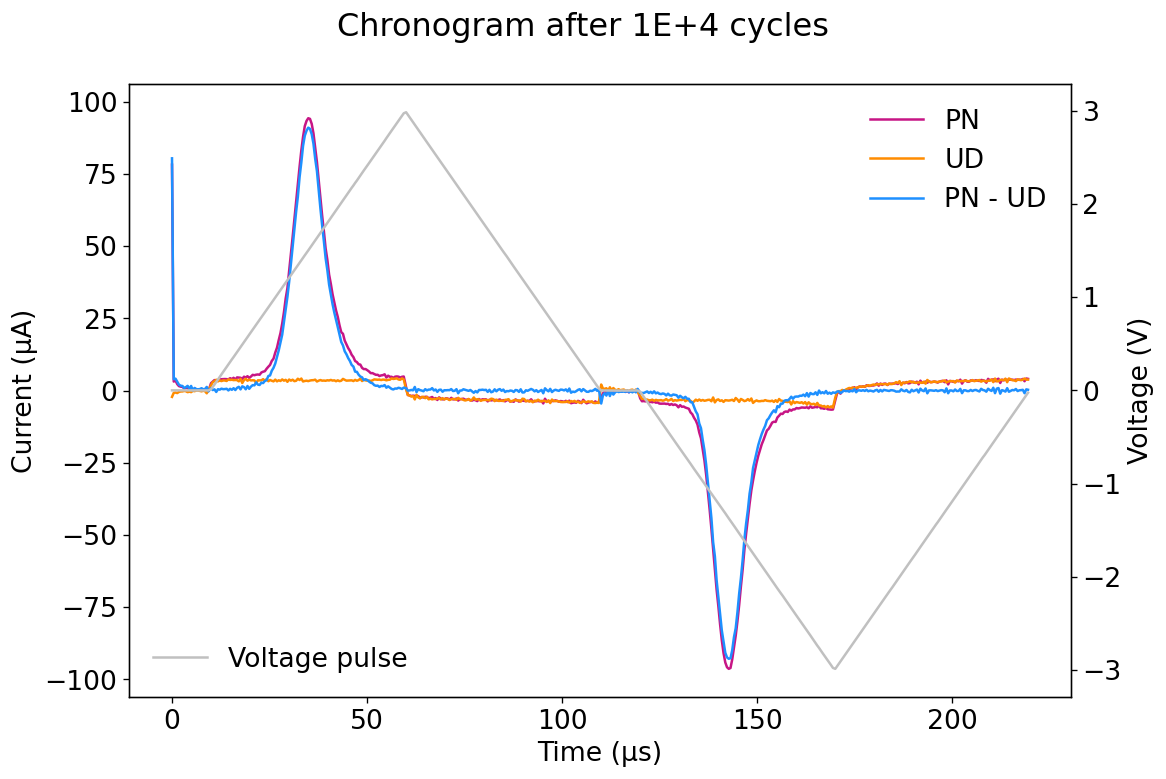

In [5]:
#PLOT THE CHRONOGRAM WITH TIME AS X SCALE

a = "{:.0E}".format(Decimal(Cycle_to_plot))
timer0 = getTime(Index, P_current[Index], N_current[Index], timescale)          #the timescale isn't the same between each segment
timer1 = getTime(Index, U_current[Index], D_current[Index], timescale)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

if float(a) < 100:
    if a==1:
        fig.suptitle('Chronogram at pristine state')
    else:
        abis = float(a)
        fig.suptitle('Chronogram after '  + str(int(abis)) + ' cycles')
else:
    fig.suptitle('Chronogram after '  + a + ' cycles')

ax1 = fig.add_subplot(111)

ax1.plot(timer0,PN_current[Index].IMeasCh2*units*f, "mediumvioletred", label = 'PN')
ax1.plot(timer1,UD_current[Index].IMeasCh2*units*f, "darkorange", label = 'UD')
plt.plot(timer0,(PN_current[Index].IMeasCh2-UD_current[Index].IMeasCh2)*units*f, "dodgerblue", label = 'PN - UD')
ax1.set_ylabel('Current (µA)')
ax1.set_xlabel('Time (µs)')
#ax1.set_ylim([-1000,1000])
ax1.set_ylim([max(abs(PN_current[Index].IMeasCh2))*units*1.1*f,-max(abs(PN_current[Index].IMeasCh2))*units*1.1*f])       #change the sign of the limits depending of the setup
plt.legend(loc="upper right", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(timer0,PN_current[Index].VMeasCh1, 'silver', label = 'Voltage pulse')
ax2.set_ylabel('Voltage (V)')
plt.legend(loc="lower left", frameon = False)
plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_' + 'chronogram at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

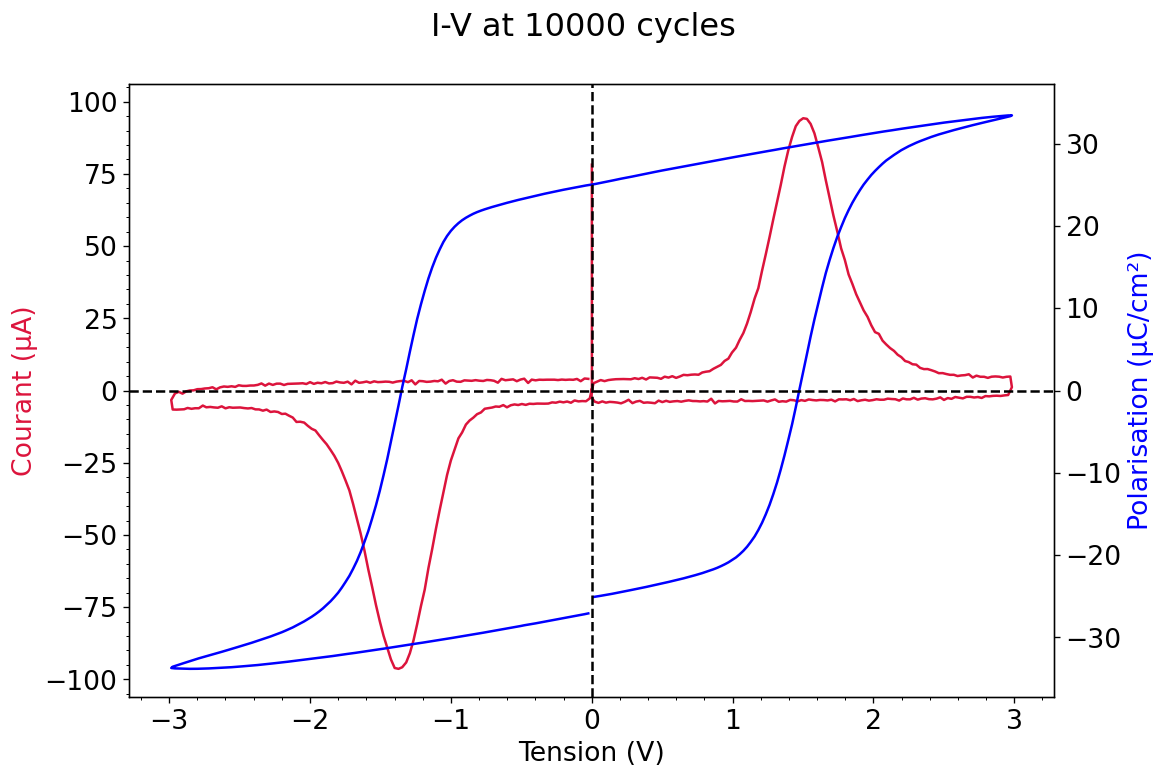

In [6]:
#SAME WITH VOLTAGE AS X SCALE
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
#f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)

P_pos, P_neg, Pr_pos, Pr_neg, V_pos, V_neg = getPUND(P_current[Index], N_current[Index], f, Waiting)
P_up, P_down, Pr_up, Pr_down, V_up, V_down = getPUND(U_current[Index], D_current[Index], f, Waiting)
#print(len(P_pos),len(P_up),len(V_pos),len(V_up))
#print(len(P_neg),len(P_down),len(V_neg),len(V_down))
[P_pos, P_up, V_pos, V_up] = the_equalizer([P_pos, P_up, V_pos, V_up])
[P_neg, P_down, V_neg, V_down] = the_equalizer([P_neg, P_down, V_neg, V_down])
P_neg, Pr_neg = rescale(P_pos, P_neg, Pr_neg)
P_down, Pr_down = rescale(P_up, P_down, Pr_down)
Ppn = np.concatenate([P_pos,P_neg], axis=0)
Ppund = np.concatenate([P_pos-P_up,P_neg-P_down], axis=0)
Vpund = np.concatenate([V_pos,V_neg], axis=0)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

if float(a) < 100:
    if a==1:
        fig.suptitle('I-V at pristine state')
    else:
        abis = float(a)
        fig.suptitle('I-V at '  + str(int(abis)) + ' cycles')
else:
    abis = float(a)
    fig.suptitle('I-V at '  + str(int(abis)) + ' cycles')
ax1 = fig.add_subplot(111)

ax1.plot(PN_current[Index].VMeasCh1,PN_current[Index].IMeasCh2*units*f, "crimson")
#ax1.plot(UD_current[Index].VMeasCh1,abs(UD_current[Index].IMeasCh2*units*f), "darkorange", label = 'UD')
#plt.plot(PN_current[Index].VMeasCh1,abs((PN_current[Index].IMeasCh2-UD_current[Index].IMeasCh2)*units*f), "dodgerblue", label = 'PN - UD')
ax1.minorticks_on()
#ax1.tick_params(axis='y', which='minor', left=False)
ax1.set_ylabel('Courant (µA)', color = 'crimson')
ax1.set_xlabel('Tension (V)')
#ax1.set_yscale('log')
ax1.set_ylim([-1.1*units*max(abs(min(PN_current[Index].IMeasCh2)),max(PN_current[Index].IMeasCh2)),1.1*units*max(abs(min(PN_current[Index].IMeasCh2)),max(PN_current[Index].IMeasCh2))])       #change the sign of the limits depending of the setup

ax2 = ax1.twinx()
ax2.plot(Vpund, Ppn, "blue")
ax2.set_ylim([-1.1*max(abs(min(P_neg)),max(P_pos)),1.1*max(abs(min(P_neg)),max(P_pos))])
ax2.set_ylabel('Polarisation (µC/cm\u00b2)', color = 'blue')

plt.axvline(x=0, ls='--', color='black')
plt.axhline(y=0, ls='--', color='black')
#plt.legend(loc="lower right", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_' + 'P-V at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

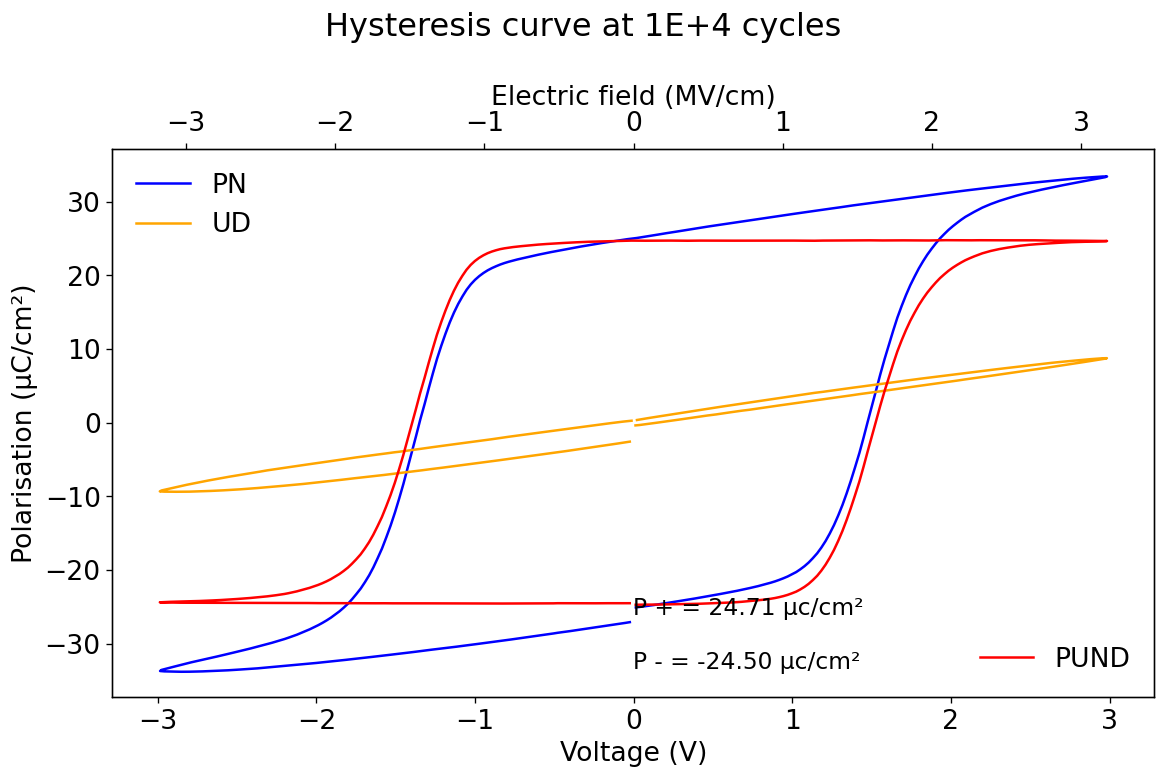

In [123]:
#PLOT THE HYSTERESIS CURVE
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
#f = 1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)
    
plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Hysteresis curve at '  + a + ' cycles')
ax1 = fig.add_subplot(111)

ax1.plot(Vpund, Ppn, "blue", label = 'PN')
ax1.plot(V_up, P_up, "orange", label = 'UD')
ax1.plot(V_down, P_down, "orange")
#ax1.set_xlim([-4,4])
ax1.set_ylim([-1.1*max(abs(min(P_neg)),max(P_pos)),1.1*max(abs(min(P_neg)),max(P_pos))])
ax1.set_ylabel('Polarisation (µC/cm\u00b2)')
ax1.set_xlabel('Voltage (V)')
plt.legend(loc="upper left", frameon = False)

ax2 = ax1.twiny()
ax2.plot(Vpund*1e-6/t_ox, Ppund, "red", label = 'PUND')
ax2.set_xlabel('Electric field (MV/cm)')
#ax2.set_xlim([-4,4])
xlim = (ax2, [-4*1e-6/t_ox, 4*1e-6/t_ox])
plt.legend(loc="lower right", frameon = False)
plt.text(0.5, 0.15, "P + = {:04.2f} µc/cm\u00b2" .format(Pr_pos-Pr_up),horizontalalignment='left', fontsize=14, transform = ax1.transAxes)
plt.text(0.5, 0.05, "P - = {:04.2f} µc/cm\u00b2" .format(Pr_neg-Pr_down),horizontalalignment='left', fontsize=14, transform = ax1.transAxes)

plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_' + 'PUND hysteresis at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

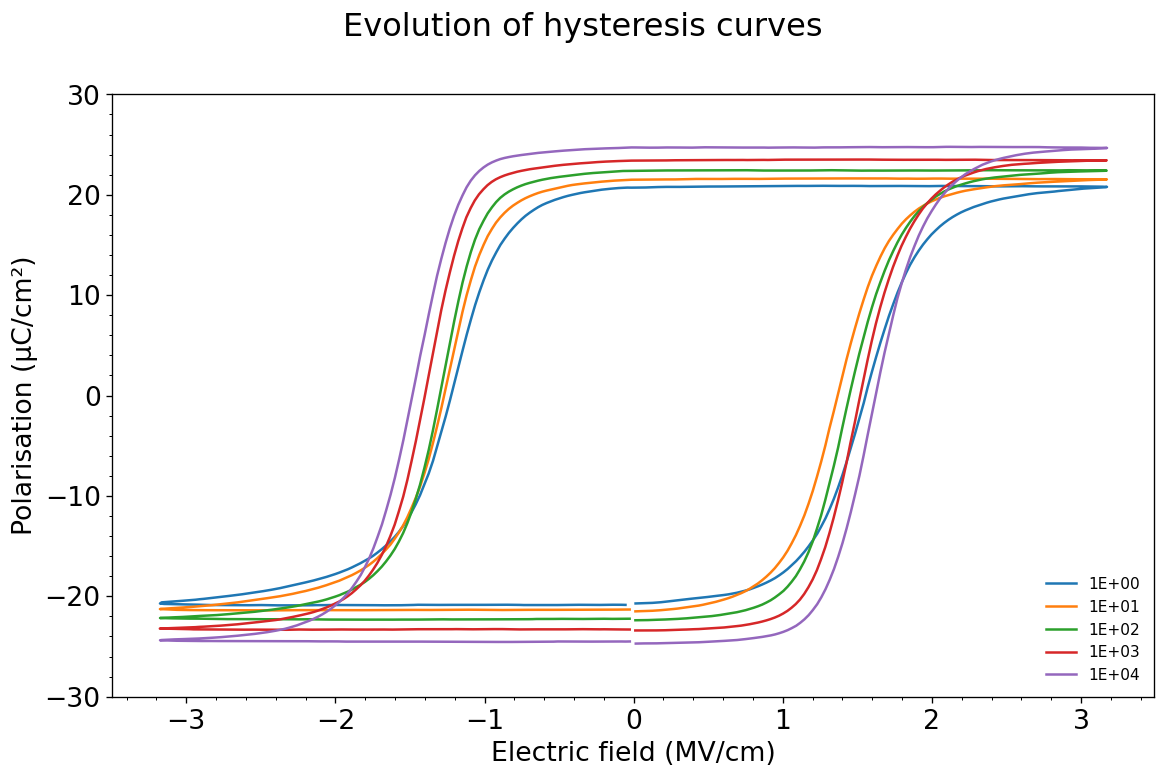

In [7]:
#PLOT THE EVOLUTION OF HYSTERESIS CURVES
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of hysteresis curves')

Pr_plus = []
Pr_minus = []
Ppund = []
Ppund_pos = []
Ppund_neg = []
Epund = []
Epund_pos = []
Epund_neg = []
Ec_pos = []
Ec_neg = []
leak_pos = []
leak_neg = []
leakd_pos = []
leakd_neg = []
x=0

#CyclesID = CyclesID[:-1]  
for i in range(0,len(CyclesID)):
    P_pos, P_neg, Pr_pos, Pr_neg, V_pos, V_neg = getPUND(P_current[i], N_current[i], f, Waiting)
    P_up, P_down, Pr_up, Pr_down, V_up, V_down = getPUND(U_current[i], D_current[i], f, Waiting)
    [P_pos, P_up, V_pos, V_up] = the_equalizer([P_pos, P_up, V_pos, V_up])
    [P_neg, P_down, V_neg, V_down] = the_equalizer([P_neg, P_down, V_neg, V_down])
    P_neg, Pr_neg = rescale(P_pos, P_neg, Pr_neg)
    P_down, Pr_down = rescale(P_up, P_down, Pr_down)
    A = np.concatenate([P_pos-P_up,P_neg-P_down], axis=0)
    Ppund.append(A)                                               #save the entire hysteresis
    Ppund_pos.append(P_pos-P_up)                 #save the positive and negative part of the hysteresis separately
    Ppund_neg.append(P_neg-P_down)
    B = np.concatenate([V_pos*1e-6/t_ox,V_neg*1e-6/t_ox], axis=0)
    Epund.append(B)
    Epund_pos.append(V_pos*1e-6/t_ox)
    Epund_neg.append(V_neg*1e-6/t_ox)
    Pr_plus.append(Pr_pos-Pr_up)                          #save the remanent polarisation values by taking the last value of each half hysteresis
    Pr_minus.append(Pr_neg-Pr_down)
    Ec_pos.append(get_Ec(Ppund_pos[i], Epund_pos[i]))      #save the coercive field
    Ec_neg.append(get_Ec(Ppund_neg[i], Epund_neg[i]))
    
    leak_p, leak_n,leakd_p, leakd_n = get_leakage (P_current[i], N_current[i], f, Waiting)
    leak_pos.append(leak_p)
    leak_neg.append(leak_n)
    leakd_pos.append(leakd_p)
    leakd_neg.append(leakd_n)
    
    if CyclesID[i]==1 or CyclesID[i] == 10**x or i == len(CyclesID)-1: #or i % 9 == 4:
        ID = '%.0E' % Decimal(CyclesID[i])
        plt.plot(B, A, label=str(ID))
        x+=1

scale_factor = 1.1
ymin, ymax = plt.ylim()
if abs(ymin) >= abs(ymax):
    plt.ylim([round_x(ymin, 5), -round_x(ymin, 5)])
else:
    plt.ylim([-round_x(ymax, 5), round_x(ymax, 5)])
#plt.ylim([-25,25])
plt.xlabel('Electric field (MV/cm)')
plt.minorticks_on()
plt.ylabel('Polarisation (µC/cm\u00b2)')
plt.legend(loc="lower right", frameon = False, fontsize = 'xx-small')

plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_' + 'evolution_of_PUND_hysteresis.png'), bbox_inches='tight') #saves the figure in .png

/tmp/ipykernel_812/866786616.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


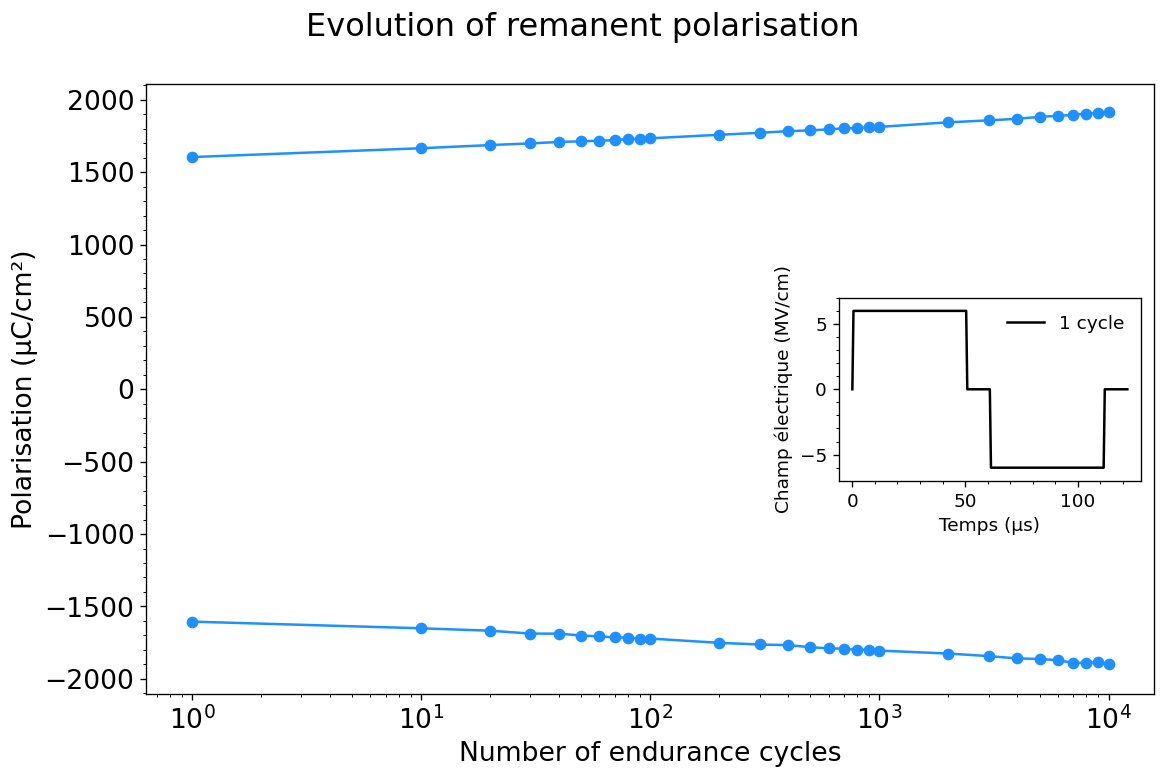

In [91]:
## plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)
ax = fig.add_subplot(111)
fig.suptitle('Evolution of remanent polarisation')

# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins = inset_axes(ax, width="30%", height="30%", loc='center right')
#CyclesID = CyclesID[:-1]
ax.plot(CyclesID, Pr_plus,'o-',color = 'dodgerblue')
ax.plot(CyclesID, Pr_minus,'o-',color = 'dodgerblue')

ax.set_xscale("log")
ax.set_xlabel('Number of endurance cycles')
ax.set_ylabel('Polarisation (µC/cm\u00b2)')
scale_factor = 1.1
ymin, ymax = ax.get_ylim()
if abs(ymin) >= abs(ymax):
    ax.set_ylim([round_x(ymin, 2), -round_x(ymin, 2)])
else:
    ax.set_ylim([-round_x(ymax, 2), round_x(ymax, 2)])
#ax.set_ylim([-22,22])
ax.minorticks_on()
#ax.legend(loc="best" , frameon=False)

Time, Efield = create_cycle(Vmax*2, Vmin*2)
axins.plot(Time, Efield, 'black', label = '1 cycle')
axins.set_xlabel('Temps (µs)',fontsize='x-small')
axins.set_ylabel('Champ électrique (MV/cm)', fontsize='x-small')
ymin2, ymax2 = axins.get_ylim()
if abs(ymin2) >= abs(ymax2):
    axins.set_ylim([round_x(ymin2, 0.5), -round_x(ymin2, 0.5)])
else:
    axins.set_ylim([-round_x(ymax2, 0.5), round_x(ymax2, 0.5)])
axins.minorticks_on()
axins.tick_params(axis='both',labelsize='x-small')
axins.legend(loc="upper right", frameon = False, fontsize='x-small')

plt.tight_layout()
#plt.savefig(data_folder / (sample + '_' + FTJ + '_evolution_of_Pr.png'), bbox_inches='tight') #saves the figure in .png

/tmp/ipykernel_812/4157689093.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


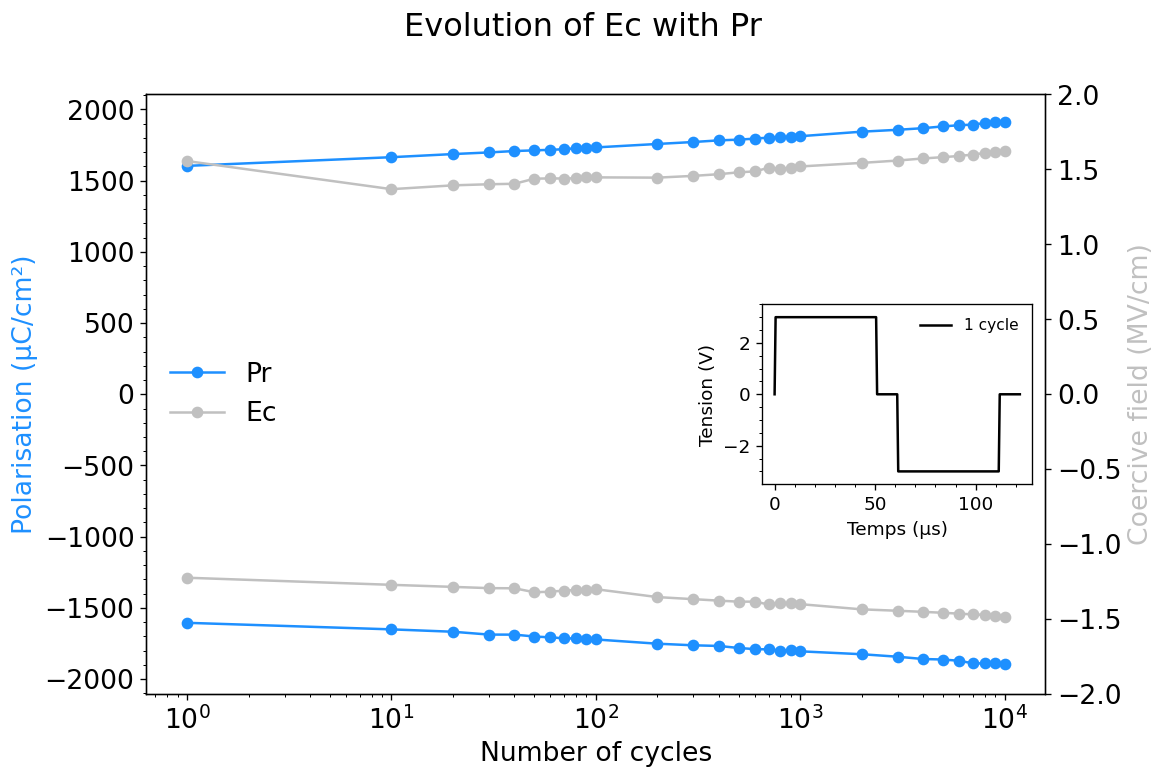

In [92]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of Ec with Pr')

ax1 = fig.add_subplot(111)

ax1.plot(CyclesID, Pr_plus,'o-',color = 'dodgerblue', label = 'Pr')
ax1.plot(CyclesID, Pr_minus,'o-',color = 'dodgerblue')
ax1.set_ylabel('Polarisation (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
ax1.minorticks_on()
ymin, ymax = ax1.get_ylim()
if abs(ymin) >= abs(ymax):
    ax1.set_ylim([round_x(ymin, 2), -round_x(ymin, 2)])
else:
    ax1.set_ylim([-round_x(ymax, 2), round_x(ymax, 2)])      #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(CyclesID, Ec_pos, 'o-',color = 'silver', label = 'Ec')
ax2.plot(CyclesID, Ec_neg, 'o-',color = 'silver')
ax2.set_ylabel('Coercive field (MV/cm)', color = 'silver')
ymin2, ymax2 = ax2.get_ylim()
if abs(ymin2) >= abs(ymax2):
    ax2.set_ylim([round_x(ymin2, 0.5), -round_x(ymin2, 0.5)])
else:
    ax2.set_ylim([-round_x(ymax2, 0.5), round_x(ymax2, 0.5)])
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc='center left', frameon= False)

axins = inset_axes(ax2, width="30%", height="30%", loc='center right')
Time, Efield = create_cycle(Vmax, Vmin)
axins.plot(Time, Efield, 'black', label = '1 cycle')
axins.set_xlabel('Temps (µs)',fontsize='x-small')
axins.set_ylabel('Tension (V)', fontsize='x-small')
ymin3, ymax3 = axins.get_ylim()
if abs(ymin3) >= abs(ymax3):
    axins.set_ylim([round_x(ymin3, 0.5), -round_x(ymin3, 0.5)])
else:
    axins.set_ylim([-round_x(ymax3, 0.5), round_x(ymax3, 0.5)])
axins.minorticks_on()
axins.tick_params(axis='both',labelsize='x-small')
axins.legend(loc="upper right", frameon = False, fontsize='xx-small')

#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_evolution_of_Ec_with_Pr.png'), bbox_inches='tight') #saves the figure in .png

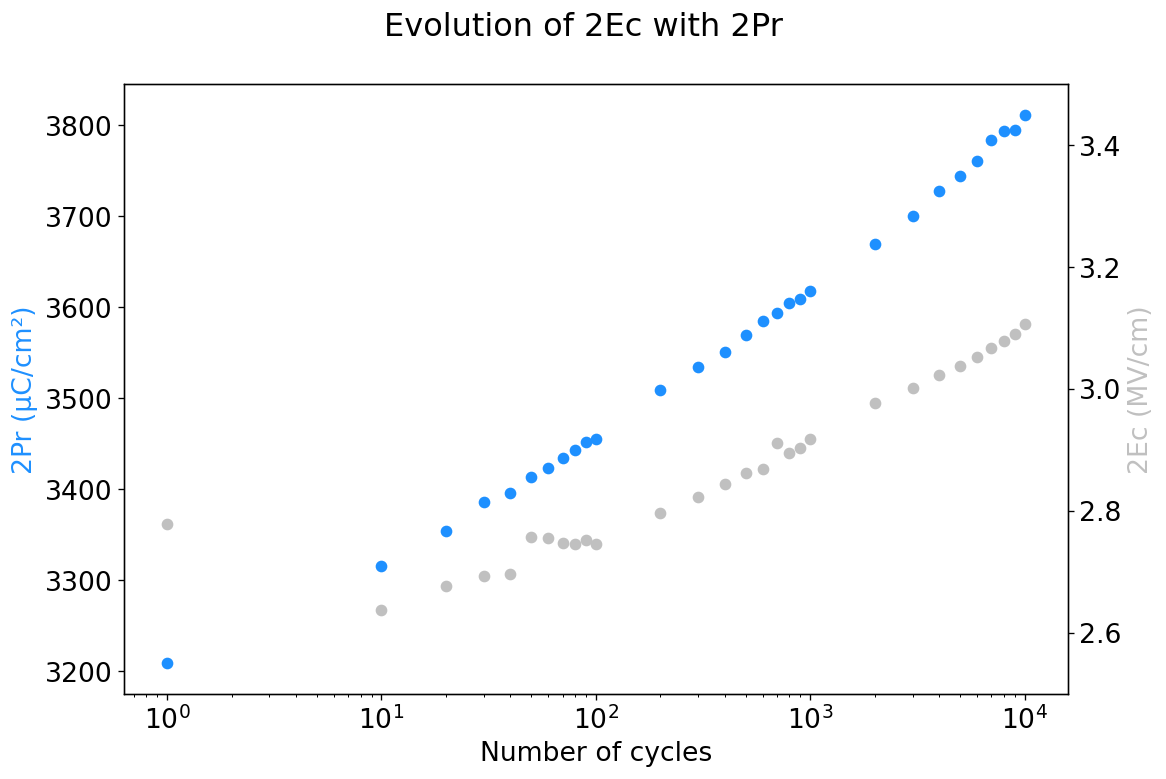

In [93]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of 2Ec with 2Pr')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for i in range(0,len(CyclesID)):
    ax1.plot(CyclesID[i], Pr_plus[i]-Pr_minus[i],'o-',color = 'dodgerblue')
    ax2.plot(CyclesID[i], Ec_pos[i]-Ec_neg[i], 'o-',color = 'silver')
ax1.set_ylabel('2Pr (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([round_x(ymin, 5)-5, round_x(ymax, 5)])
#ax1.set_ylim([30,50])
#ax1.set_ylim([max(abs(PN_current[Index].IMeasCh2))*units*1.1*f,-max(abs(PN_current[Index].IMeasCh2))*units*1.1*f])       #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2.set_ylabel('2Ec (MV/cm)', color = 'silver')
ymin2, ymax2 = ax2.get_ylim()
ax2.set_ylim([round_x(ymin2, 0.5)-0.5, round_x(ymax2, 0.5)])
#ax2.set_ylim([2, 3.5])
#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_evolution_of_2Ec_with_2Pr.png'), bbox_inches='tight') #saves the figure in .png

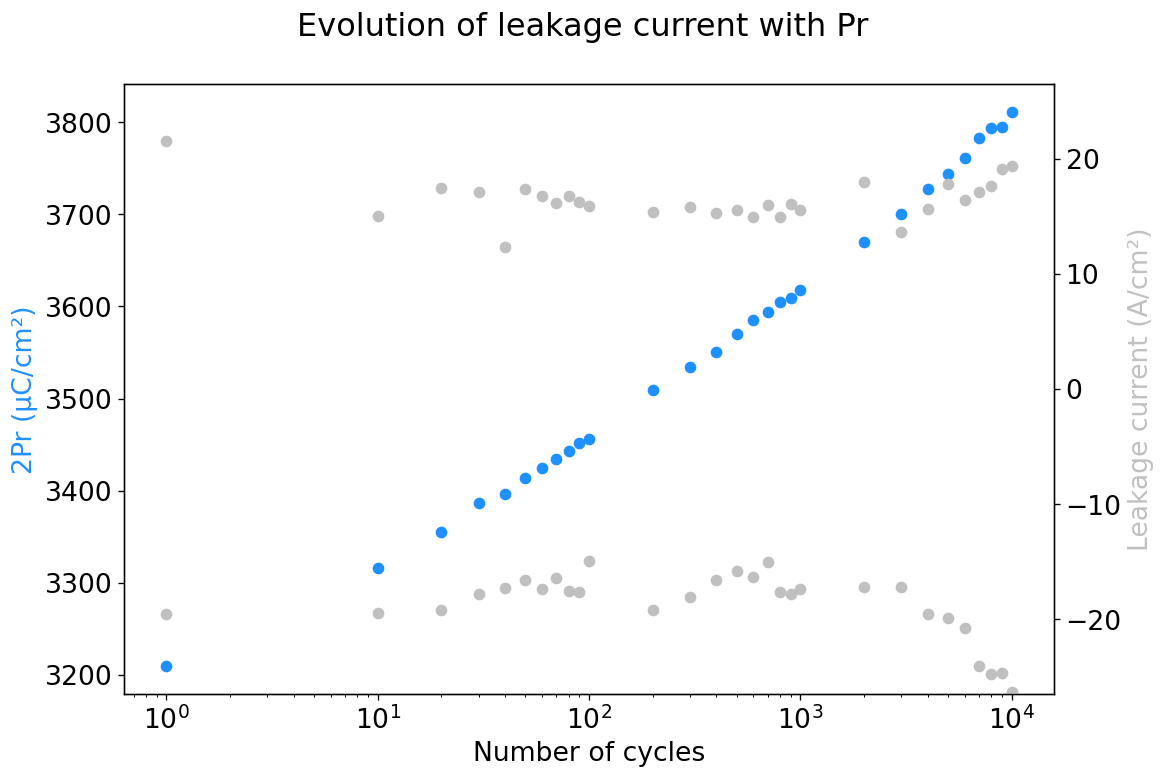

In [94]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of leakage current with Pr')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for i in range(0,len(CyclesID)):
    ax1.plot(CyclesID[i], Pr_plus[i]-Pr_minus[i],'o-',color = 'dodgerblue')
    ax2.plot(CyclesID[i], leakd_pos[i], 'o-',color = 'silver')
    ax2.plot(CyclesID[i], leakd_neg[i], 'o-',color = 'silver')
ax1.set_ylabel('2Pr (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
#lim = max(Pr_plus)+max(Pr_minus)
#ax1.set_ylim([0 ,round_x(lim, 5)])
#ax1.set_ylim([max(abs(PN_current[Index].IMeasCh2))*units*1.1*f,-max(abs(PN_current[Index].IMeasCh2))*units*1.1*f])       #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2.set_ylabel('Leakage current (A/cm\u00b2)', color = 'silver')
lim2 = max(max(leakd_pos), -min(leakd_neg))
ax2.set_ylim([round_x(-lim2, 0.5), round_x(lim2, 0.5)])
#ax2.set_yscale("log")
#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder / (sample + '_' + FTJ + '_evolution_of_leakage current_with_2Pr.png'), bbox_inches='tight') #saves the figure in .png

In [98]:
##Save ferroelectric properties and the hysteresis of each cycle in xls files
Pr = [m - n for m,n in zip(Pr_plus,Pr_minus)]
Ec = [y - z for y,z in zip(Ec_pos,Ec_neg)]

d= {'CyclesID': CyclesID, 'Pr_plus': Pr_plus, 'Pr_minus': Pr_minus, '2Pr': Pr, 'Ec_pos': Ec_pos, 'Ec_neg': Ec_neg, '2Ec': Ec, 'Leakage_pos': leak_pos,'Leakage_neg': leak_neg,'Leakage_density_pos': leakd_pos,'Leakage_density_neg': leakd_neg}
df = pd.DataFrame(data=d)
df.to_csv(data_folder / ('Ferroelectric properties per cycle.csv'), index=False, sep='\t')

print(str(sample)+'-'+str(FTJ)+'\nProperties saved')

datas = {'Electric field (MV/cm)': Epund[0], 'Polarisation (µC/cm\u00b2)':Ppund[0]}
dataf = pd.DataFrame(data=datas)
datas2 = {'Electric field (MV/cm)': PN_current[0].VMeasCh1*1e-6/t_ox,'PN_current (A/cm\u00b2)':PN_current[0].IMeasCh2*f/S}
dataf2 = pd.DataFrame(data=datas2)
dataf.to_excel(data_folder / ('Hystereses.xls'), sheet_name=str(CyclesID[0]))
dataf2.to_excel(data_folder / ('PN_current.xls'), sheet_name=str(CyclesID[0]))

with pd.ExcelWriter(data_folder / ('Hystereses.xls'), engine= 'openpyxl', mode='a') as writer:
    for i in range(1,len(CyclesID)):
        datas = {'Electric field (MV/cm)': Epund[i], 'Polarisation (µC/cm\u00b2)':Ppund[i]}
        dataf = pd.DataFrame(data=datas)
  
        dataf.to_excel(writer, sheet_name=str(CyclesID[i]))

print('Hystereses saved')

with pd.ExcelWriter(data_folder / ('PN_current.xls'), engine= 'openpyxl', mode='a') as writer2:
    for i in range(1,len(CyclesID)):
        datas2 = {'Electric field (MV/cm)': PN_current[i].VMeasCh1*1e-6/t_ox,'PN_current (A/cm\u00b2)':PN_current[i].IMeasCh2*f/S}
        dataf2 = pd.DataFrame(data=datas2)
        
        dataf2.to_excel(writer2, sheet_name=str(CyclesID[i]))    

print('PN current saved')

Q294E-br32
Properties saved
Hystereses saved
PN current saved


In [ ]:
(PN_current[Index].TimeOutput[:-243]-PN_current[Index].TimeOutput[0], PN_current[Index].IMeasCh2[:-243])

(0      0.000000e+00
 1      6.050000e-07
 2      1.210000e-06
 3      1.815000e-06
 4      2.420000e-06
            ...     
 243    1.477950e-04
 244    1.484000e-04
 245    1.490050e-04
 246    3.006050e-04
 247    3.012100e-04
 Name: TimeOutput, Length: 248, dtype: float64,
 0     -0.000093
 1      0.000029
 2     -0.000006
 3     -0.000004
 4     -0.000003
          ...   
 243    0.000018
 244    0.000019
 245    0.000019
 246    0.000006
 247    0.000004
 Name: IMeasCh2, Length: 248, dtype: float64)

In [ ]:
(UD_current[Index].TimeOutput[:-245]-UD_current[Index].TimeOutput[0], UD_current[Index].IMeasCh2[:-245])

(0      0.000000e+00
 1      6.050000e-07
 2      1.210000e-06
 3      1.815000e-06
 4      2.420000e-06
            ...     
 243    1.477950e-04
 244    1.484000e-04
 245    1.490050e-04
 246    1.500000e-04
 247    3.000000e-04
 Name: TimeOutput, Length: 248, dtype: float64,
 0      0.000013
 1      0.000006
 2      0.000005
 3      0.000005
 4      0.000004
          ...   
 243    0.000018
 244    0.000018
 245    0.000019
 246    0.000012
 247   -0.000011
 Name: IMeasCh2, Length: 248, dtype: float64)

In [96]:
df

,CyclesID,Pr_plus,Pr_minus,2Pr,Ec_pos,Ec_neg,2Ec,Leakage_pos,Leakage_neg,Leakage_density_pos,Leakage_density_neg
0,1.0,1604.123408,-1604.934043,3209.057451,1.555386,-1.223468,2.778854,0.000005,-0.000005,21.561527,-19.505793
1,10.0,1664.986769,-1650.926936,3315.913705,1.367995,-1.270780,2.638775,0.000004,-0.000005,15.081129,-19.437128
2,20.0,1686.956759,-1667.619337,3354.576096,1.393411,-1.284497,2.677908,0.000004,-0.000005,17.527569,-19.142486
3,30.0,1698.497760,-1687.569190,3386.066950,1.400772,-1.292799,2.693571,0.000004,-0.000004,17.161141,-17.764123
4,40.0,1708.380608,-1687.913918,3396.294526,1.403984,-1.293871,2.697855,0.000003,-0.000004,12.366846,-17.246623
5,50.0,1712.898387,-1701.027798,3413.926185,1.437818,-1.320171,2.757989,0.000004,-0.000004,17.393990,-16.586157
6,60.0,1717.017304,-1707.026840,3424.044145,1.439919,-1.316620,2.756539,0.000004,-0.000004,16.828399,-17.376478
7,70.0,1720.927692,-1713.950044,3434.877736,1.438826,-1.309114,2.747940,0.000004,-0.000004,16.179176,-16.360174
8,80.0,1728.288274,-1714.811147,3443.099420,1.440543,-1.305765,2.746309,0.000004,-0.000004,16.804684,-17.563741
9,90.0,1730.343106,-1721.614206,3451.957312,1.446798,-1.305790,2.752588,0.000004,-0.000004,16.271571,-17.583712
